## Strip Layers from VGG16

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
#from GPUtil import showUtilization as gpu_usage

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.models import resnet50
import torchvision.models as models

In [2]:
file_path='../model_dev/vgg16_ft.pth'

model = models.vgg16(pretrained=False)

#torch.save(vgg16_ft.state_dict(), 'vgg16_ft.pth')

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 2)])
model.classifier = nn.Sequential(*features)

#model = torch.load(file_path)
model.load_state_dict(torch.load(file_path))
#model.eval()

/home/jmwolf/anaconda3/envs/keras_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jmwolf/anaconda3/envs/keras_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
num_features = model.classifier[6]#.in_features
features = list(model.classifier.children())[:-1]
#features.extend([nn.Linear(num_features, 5)])
newmodel = model
newmodel.classifier = nn.Sequential(*features)

In [4]:
num_features = newmodel.classifier[5]#.in_features
features = list(newmodel.classifier.children())[:-1]
#features.extend([nn.Linear(num_features, 5)])
newmodel = newmodel
newmodel.classifier = nn.Sequential(*features)

In [5]:
num_features = model.classifier[4]#.in_features
features = list(model.classifier.children())[:-1]
#features.extend([nn.Linear(num_features, 5)])
newmodel = newmodel
newmodel.classifier = nn.Sequential(*features)

In [6]:
newmodel.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
def img_transform(path):
    print(torch.cuda.memory_allocated())
    transform = transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ])

    transform_normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
     )
    img = Image.open(path)
    transformed_img = transform(img)
    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)
    #print(torch.cuda.memory_allocated())
    
    
    del transform
    del transform_normalize
    del img
    del transformed_img
    #del input
    torch.cuda.empty_cache()
    
    return input

In [9]:
def extract_features(path, file, model):
    
    #img =  path + file
    img_input = img_transform(path+file)
    #print("img_input transform:", torch.cuda.memory_allocated())
    img_input = img_input.to(device)
    #print("img_input to device:", torch.cuda.memory_allocated())
    model.to(device)
    #print("model to device:", torch.cuda.memory_allocated())
    output = model(img_input)
    #print("output from model:", torch.cuda.memory_allocated())
  
    img_input.detach()
    del img_input
    #del img
    #model.detach()
    del model
    #del output
    torch.cuda.empty_cache()
    
    return output

In [10]:
path = "../model_dev/Data_CMC_COADEL_224_1/train/Mitosis/" 
# change the working directory to the path where the images are located
#os.chdir(path)
#!pwd
# this list holds all the image filename
mitosis = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the flowers list
            mitosis.append(file.name)

In [11]:
mitosis[:15]

['8739.jpg',
 '5314.jpg',
 '16105.jpg',
 '16525.jpg',
 '11038.jpg',
 '229927.jpg',
 '801.jpg',
 '15641.jpg',
 '1085.jpg',
 '16688.jpg',
 '21320.jpg',
 '17505.jpg',
 '4376.jpg',
 '32907.jpg',
 '14323.jpg']

In [12]:
data = {}
#data0 = {}

for cells in mitosis:
    with torch.no_grad():
        # try to extract the features and update the dictionary
        feat = extract_features(path, cells, newmodel)
        data[cells] = feat

0
537976832
537993216
538009600
538025984
538042368
538058752
538075136
538091520
538107904
538124288
538140672
538157056
538173440
538189824
538206208
538222592
538238976
538255360
538271744
538288128
538304512
538320896
538337280
538353664
538370048
538386432
538402816
538419200
538435584
538451968
538468352
538484736
538501120
538517504
538533888
538550272
538566656
538583040
538599424
538615808
538632192
538648576
538664960
538681344
538697728
538714112
538730496
538746880
538763264
538779648
538796032
538812416
538828800
538845184
538861568
538877952
538894336
538910720
538927104
538943488
538959872
538976256
538992640
539009024
539025408
539041792
539058176
539074560
539090944
539107328
539123712
539140096
539156480
539172864
539189248
539205632
539222016
539238400
539254784
539271168
539287552
539303936
539320320
539336704
539353088
539369472
539385856
539402240
539418624
539435008
539451392
539467776
539484160
539500544
539516928
539533312
539549696
539566080
539582464
53959884

In [13]:
filenames = list(data.keys())

In [14]:
filenames[0]

'8739.jpg'

In [15]:
data.values()

dict_values([tensor([[-0.0253, -0.1064, -0.0902,  ..., -0.0764, -0.0463, -0.0861]],
       device='cuda:0'), tensor([[-0.1313, -0.2003, -0.1697,  ..., -0.1367, -0.2743, -0.0671]],
       device='cuda:0'), tensor([[-0.1792, -0.1727, -0.1894,  ..., -0.0580, -0.1427, -0.1412]],
       device='cuda:0'), tensor([[-0.3806, -0.3926, -0.3086,  ..., -0.2050, -0.3111, -0.3790]],
       device='cuda:0'), tensor([[-1.2253, -1.4247, -1.0899,  ..., -0.7087, -0.9711, -1.3757]],
       device='cuda:0'), tensor([[ 0.0300, -0.1198, -0.0385,  ..., -0.0513,  0.0236, -0.0718]],
       device='cuda:0'), tensor([[-0.0501, -0.2363, -0.2522,  ..., -0.1330, -0.1655, -0.0510]],
       device='cuda:0'), tensor([[-0.0768, -0.2149, -0.1591,  ..., -0.1458, -0.1470, -0.0565]],
       device='cuda:0'), tensor([[-0.4011, -0.4263, -0.3458,  ..., -0.2068, -0.2565, -0.4045]],
       device='cuda:0'), tensor([[-0.4580, -0.4041, -0.2386,  ..., -0.1767, -0.2982, -0.3093]],
       device='cuda:0'), tensor([[-1.2790, -1.3555, 

In [16]:
val = data['17505.jpg'][0]

val1 = val.cpu().numpy()
val1

array([-0.6875122 , -0.7350034 , -0.5041354 , ..., -0.33114332,
       -0.4673108 , -0.68056566], dtype=float32)

In [17]:
np_list = []

for file in data.keys():
    val = data[file]
    val = val.cpu().numpy()
    np_list.append(val)

    np_list = list(np_list)

In [18]:
np_list = np.array(np_list)
np_list.shape

(10694, 1, 4096)

In [19]:
new_list = np_list.reshape(-1,4096)
new_list.shape

(10694, 4096)

In [21]:
from keras_preprocessing.image import load_img 
from keras_preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 

from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

2022-09-15 18:46:56.287119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 18:46:56.478576: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 18:46:57.110283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jmwolf/anaconda3/envs/tf_env/lib/:/home/jmwolf/anaconda3/envs/tf_env/lib/:/home/jmwolf/anaconda3/envs/tf_env/lib/
2022-09-15 18:46:57.110350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64]

In [22]:
pca = PCA(n_components=100, random_state=22)
pca.fit(new_list)
x = pca.transform(new_list)

In [23]:
kmeans = KMeans(n_clusters=5 , random_state=22)
kmeans.fit(x)

KMeans(n_clusters=5, random_state=22)

In [24]:
kmeans.labels_

array([3, 3, 3, ..., 3, 4, 3], dtype=int32)

In [25]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [26]:
len(groups[0])

1364

In [27]:
len(groups[1])

2970

In [28]:
len(groups[2])

522

In [29]:
len(groups[3])

3622

In [30]:
len(groups[4])

2216

In [32]:
from skimage import data, io

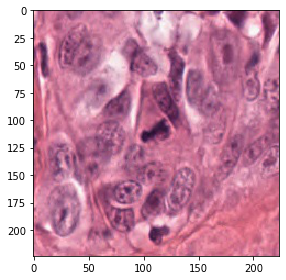

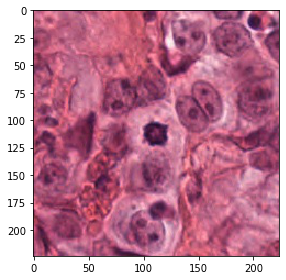

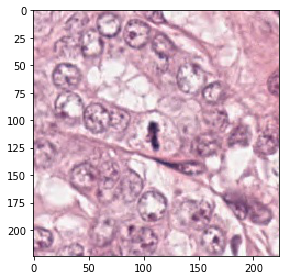

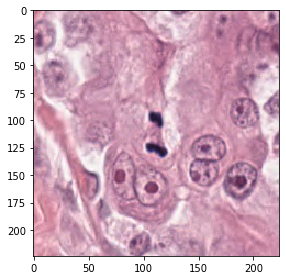

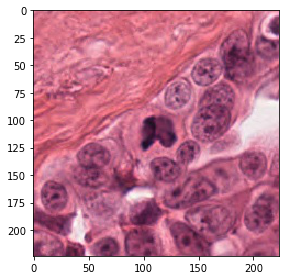

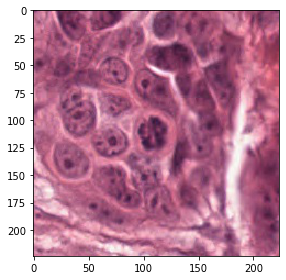

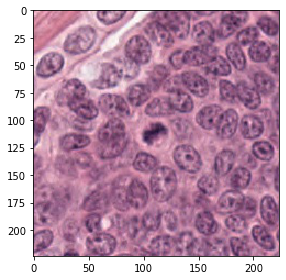

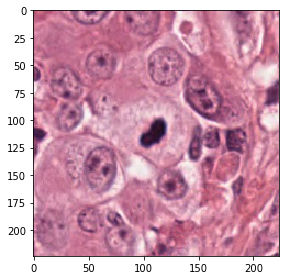

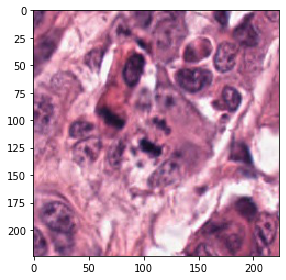

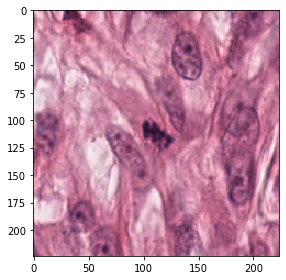

In [33]:
for x in range(10):
    io.imshow(path + '/' +groups[0][x])
    io.show()

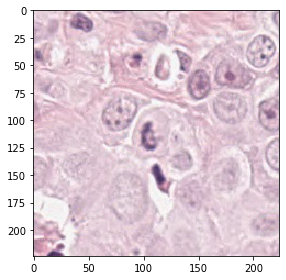

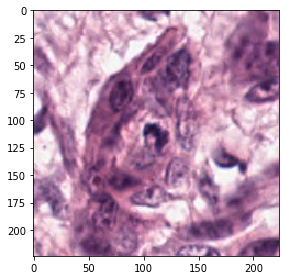

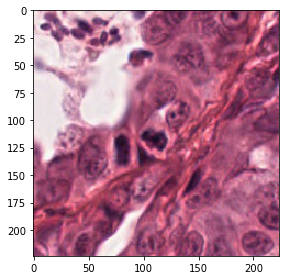

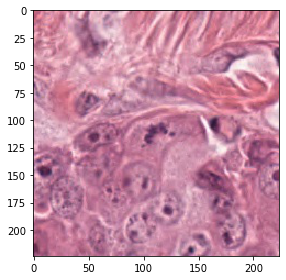

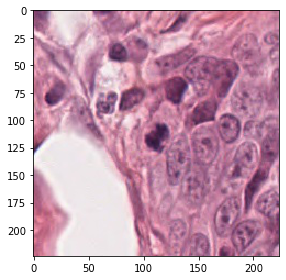

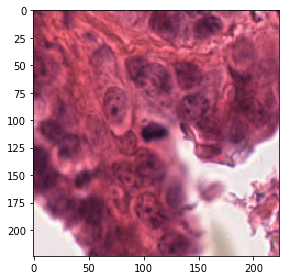

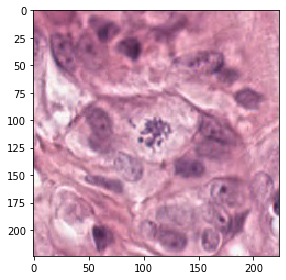

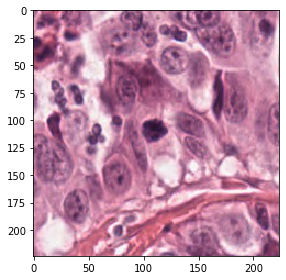

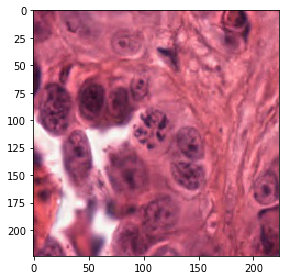

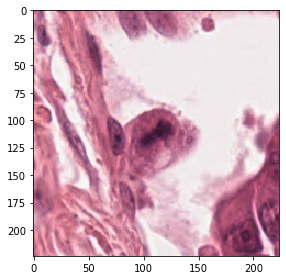

In [34]:
for x in range(10):
    io.imshow(path + '/' +groups[1][x])
    io.show()

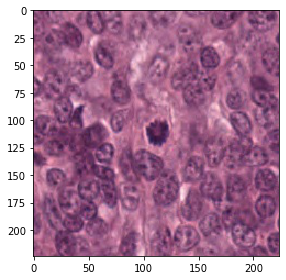

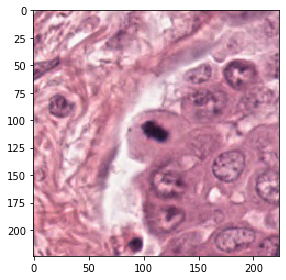

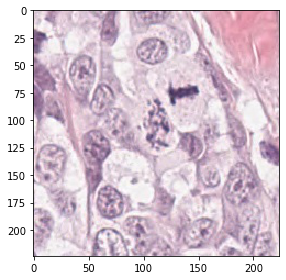

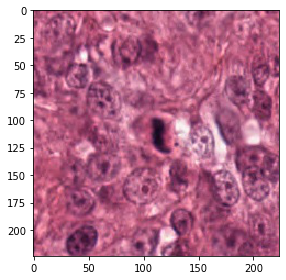

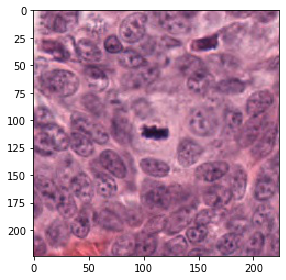

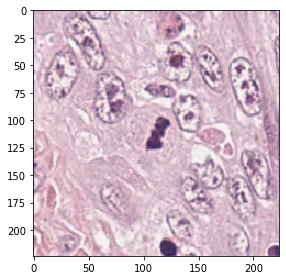

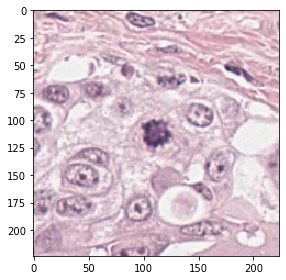

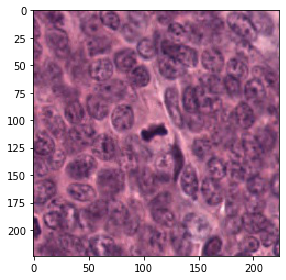

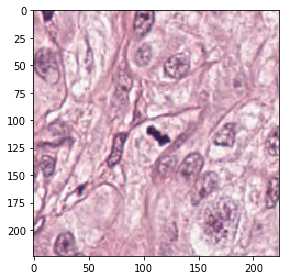

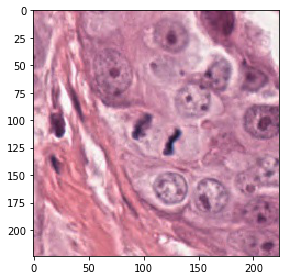

In [35]:
for x in range(10):
    io.imshow(path + '/' +groups[2][x])
    io.show()

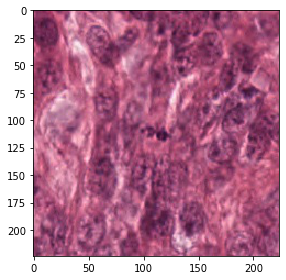

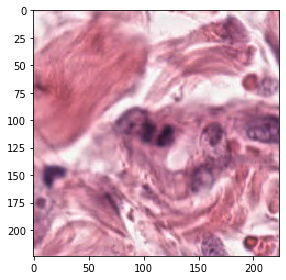

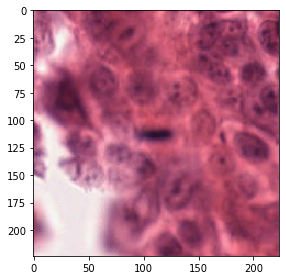

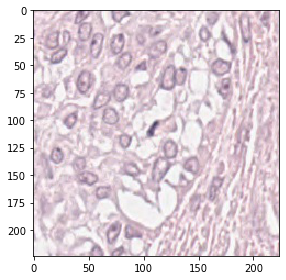

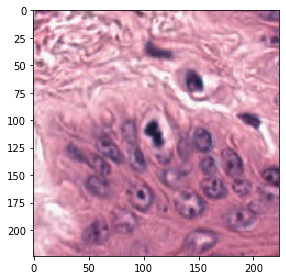

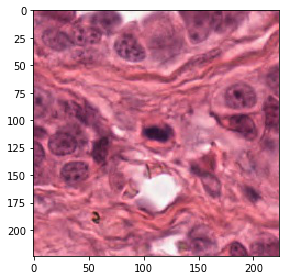

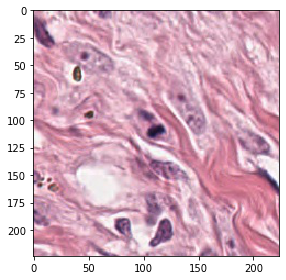

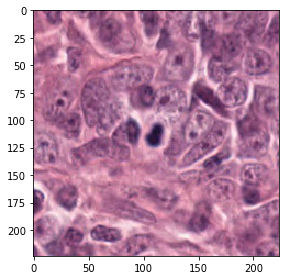

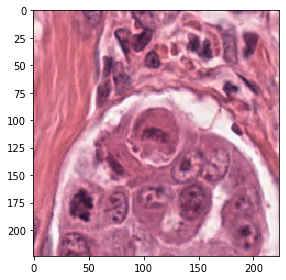

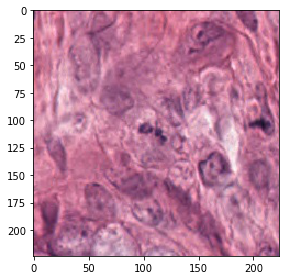

In [36]:
for x in range(10):
    io.imshow(path + '/' +groups[3][x])
    io.show()

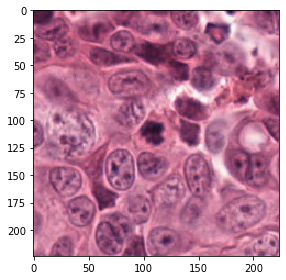

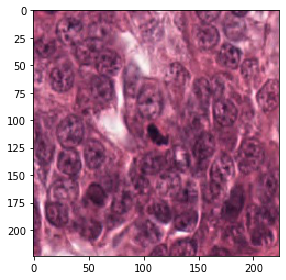

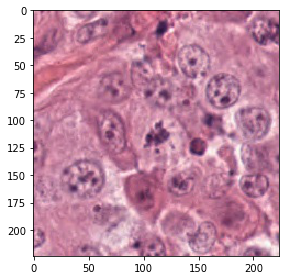

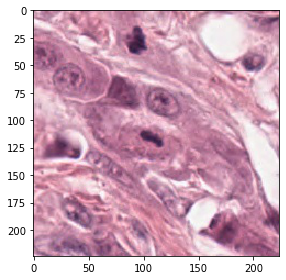

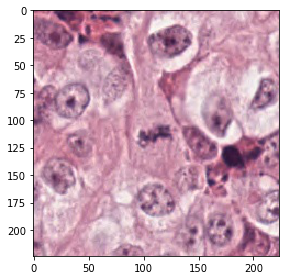

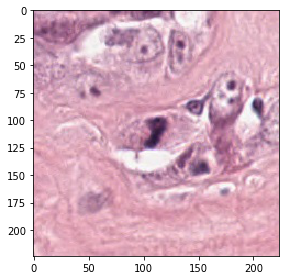

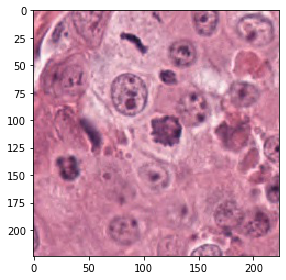

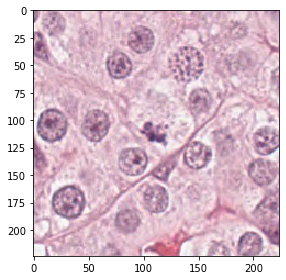

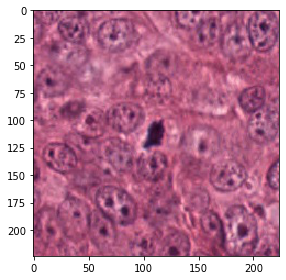

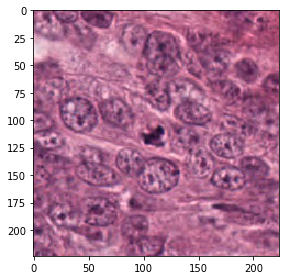

In [37]:
for x in range(10):
    io.imshow(path + '/' +groups[4][x])
    io.show()

In [38]:
!pwd

/bin/bash: /home/jmwolf/anaconda3/envs/tf_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/jmwolf/repos/XAI_Healthcare/model_dev


In [45]:
os.mkdir('vgg16_group0')
os.mkdir('vgg16_group1')
os.mkdir('vgg16_group2')
os.mkdir('vgg16_group3')
os.mkdir('vgg16_group4')

In [46]:
groups_0 = groups[0]
groups_1 = groups[1]
groups_2 = groups[2]
groups_3 = groups[3]
groups_4 = groups[4]

In [47]:
import shutil

In [48]:
dst_path = '/home/jmwolf/repos/XAI_Healthcare/model_dev/vgg16_group0'

for files in groups_0:    
    shutil.copy(path + '/' + files, dst_path)

In [49]:
dst_path = '/home/jmwolf/repos/XAI_Healthcare/model_dev/vgg16_group1'

for files in groups_1:    
    shutil.copy(path + '/' + files, dst_path)

In [50]:
dst_path = '/home/jmwolf/repos/XAI_Healthcare/model_dev/vgg16_group2'

for files in groups_2:    
    shutil.copy(path + '/' + files, dst_path)

In [51]:
dst_path = '/home/jmwolf/repos/XAI_Healthcare/model_dev/vgg16_group3'

for files in groups_3:    
    shutil.copy(path + '/' + files, dst_path)

In [52]:
dst_path = '/home/jmwolf/repos/XAI_Healthcare/model_dev/vgg16_group4'

for files in groups_4:    
    shutil.copy(path + '/' + files, dst_path)